In [1]:
import numpy as np

from collections import defaultdict
# Classes
class Individual:
    def __init__(self, ind_id):
        self.id = ind_id
        self.vcf_index = None
        self.autism_status = None
        self.sex = None

    def __repr__(self):
        return '%s' % self.id

class Family:

    def __init__(self):
        self.parents_to_children = defaultdict(list) # (mother_id, father_id) -> [child1, child2, ...]
        self.members = {}

    def add_trio(self, child_id, mother_id, father_id, child_autism_status, child_sex):
        if child_id not in self.members:
            self.members[child_id] = Individual(child_id)
            self.members[child_id].autism_status = child_autism_status
            self.members[child_id].sex = child_sex
        child = self.members[child_id]
        if mother_id not in self.members:
            self.members[mother_id] = Individual(mother_id)
        mother = self.members[mother_id]
        if father_id not in self.members:
            self.members[father_id] = Individual(father_id)
        father = self.members[father_id]

        self.parents_to_children[(mother_id, father_id)].append(child_id)

    def add_vcf_index(self, ind_id, vcf_index):
        if ind_id in self.members:
            self.members[ind_id].vcf_index = vcf_index
            
    def get_ordered_member_ids(self):
        ordered_member_ids = []
        for (mother_id, father_id), child_ids in self.parents_to_children.items():
            ordered_member_ids.extend([mother_id, father_id] + child_ids)
        ordered_member_ids = [x for x in ordered_member_ids if self.members[x].vcf_index is not None]
        return ordered_member_ids

    def get_info(self):
        ordered_member_ids = self.get_ordered_member_ids()
        return [(self.members[ind_id].autism_status, self.members[ind_id].sex) for ind_id in ordered_member_ids]
    
    def get_vcf_indices(self):
        ordered_member_ids = self.get_ordered_member_ids()
        return [self.members[ind_id].vcf_index for ind_id in ordered_member_ids if self.members[ind_id].vcf_index is not None]

In [2]:
# Pull arguments
ped_file = 'v34.forCompoundHet.ped'

# Pull family structure from ped file
families = {}
member_to_family = {}
with open(ped_file, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        fam_id, child_id, father_id, mother_id = pieces[0:4]
        if fam_id not in families:
            families[fam_id] = Family()
        families[fam_id].add_trio(child_id, mother_id, father_id, 
                                  'Autism' if pieces[5]=='2' else 'Control', 
                                  'Male' if pieces[4]=='1' else 'Female')
        member_to_family[child_id] = fam_id
        member_to_family[mother_id] = fam_id
        member_to_family[father_id] = fam_id
print('Num families:', len(families))

Num families: 756


In [3]:
family_ids = [k for k, v in families.items()]

In [8]:
import os.path
Xs = [None]*len(family_ids)
Ys = [None]*len(family_ids)
row_indices = [None]*len(family_ids)
col_indices = [None]*len(family_ids)
for i, family_id in enumerate(family_ids):
    filename = 'data/%s.v34.22.npz' % family_id
    if os.path.isfile(filename):
        data = np.load(filename)
        if 'X' in data and 'Y' in data and 'row_indices' in data and 'col_indices' in data:
            Xs[i] = data['X']
            Ys[i] = data['Y']
            row_indices[i] = data['row_indices']
            col_indices[i] = data['col_indices']


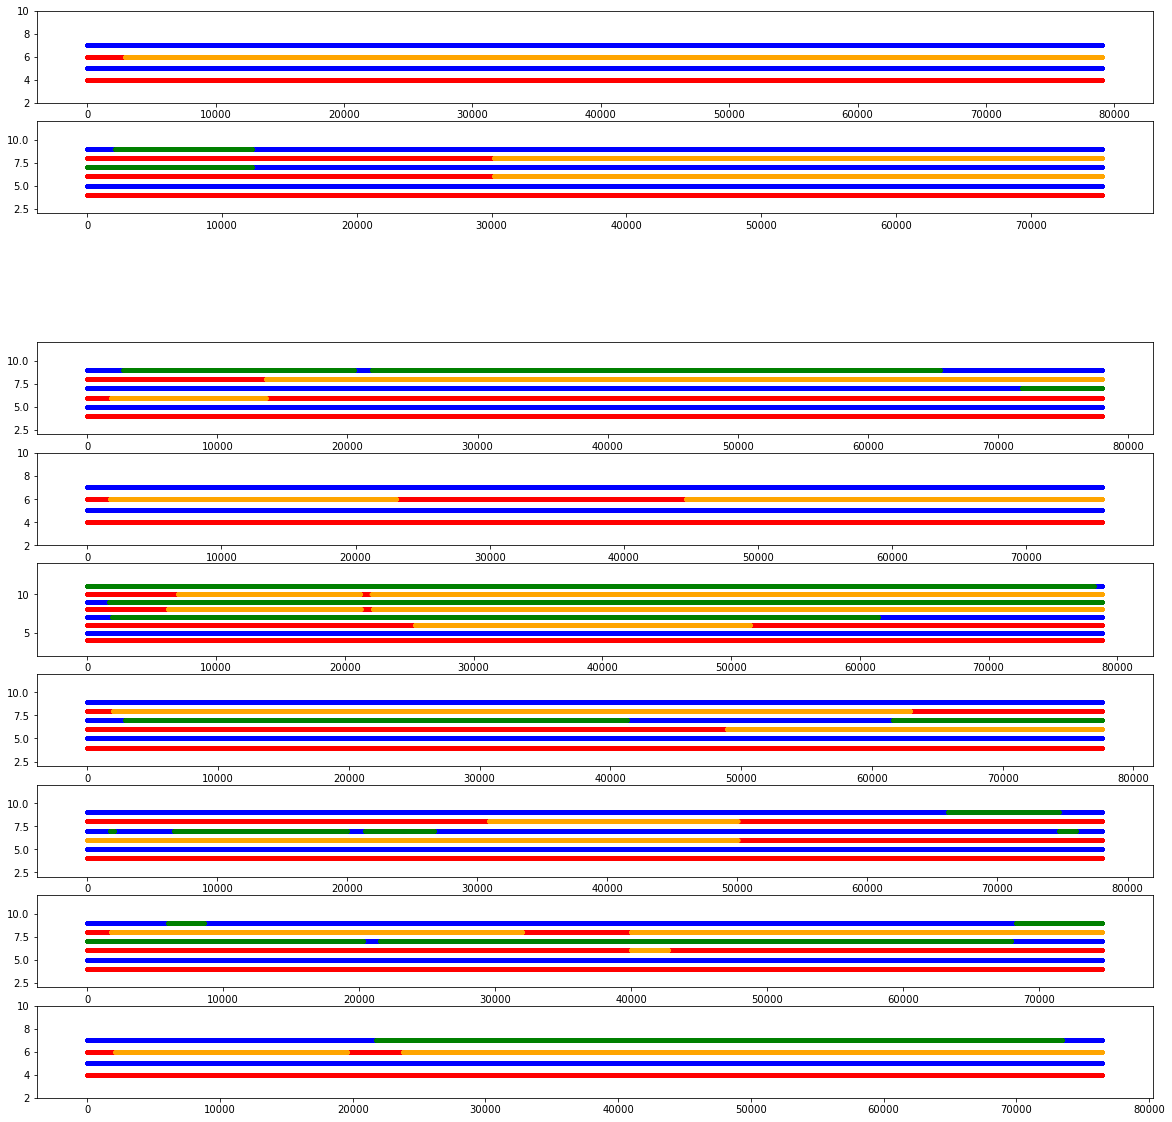

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))

n = 10
for k, X in enumerate(Xs[:n]):
    if X is not None:
        m, _, _ = X.shape
        plt.subplot(n, 1, k+1)
        for i in range(2, m):
            plt.plot(2*i*X[i, 0, :], linestyle='None', marker='.', color='red')
            plt.plot(2*i*X[i, 1, :], linestyle='None', marker='.', color='orange')
            plt.plot(2*i*X[i, 2, :]+1, linestyle='None', marker='.', color='blue')
            plt.plot(2*i*X[i, 3, :]+1, linestyle='None', marker='.', color='green')

        axes = plt.gca()
        axes.set_ylim([2,(m+1)*2])

plt.show()

In [21]:
maternal_recombinations = []
paternal_recombinations = []
for k, X in enumerate(Xs):
    if X is not None:
        m, _, n = X.shape
        for j in range(3, m):
            maternal_recombinations.extend([col_indices[k][i] for i in range(n-1) if X[j, 0, i] != X[j, 0, i+1]])
            paternal_recombinations.extend([col_indices[k][i] for i in range(n-1) if X[j, 2, i] != X[j, 2, i+1]])
            #print(maternal_recombinations, paternal_recombinations)

In [26]:
maternal_recombinations.sort()
paternal_recombinations.sort()
print(len(maternal_recombinations), len(paternal_recombinations))

3298 3093


In [53]:
variants = []
with open('v34.22.txt', 'r') as f:
    for line in f:
        variants.append(int(line.strip()))

In [54]:
# Pull recombination rate from Kong paper
# https://www.ncbi.nlm.nih.gov/pubmed/12053178?dopt=Abstract&holding=npg

rec = [0]*len(variants)
rec_female = [0]*len(variants)
rec_male = [0]*len(variants)
i = 0
with open('recombRate.txt') as f:
    for line in f:
        pieces = line.split('\t')
        chrom = pieces[0]
        start, end = [int(x) for x in pieces[1:3]]
        avg_rec, avg_rec_female, avg_rec_male = [float(x) for x in pieces[4:7]]
        
        if chrom == 'chr22':
            while i < len(variants) and variants[i] < start:
                i += 1
            while i < len(variants) and variants[i] < end:
                rec[i], rec_female[i], rec_male[i] = avg_rec, avg_rec_female, avg_rec_male
                i += 1
        

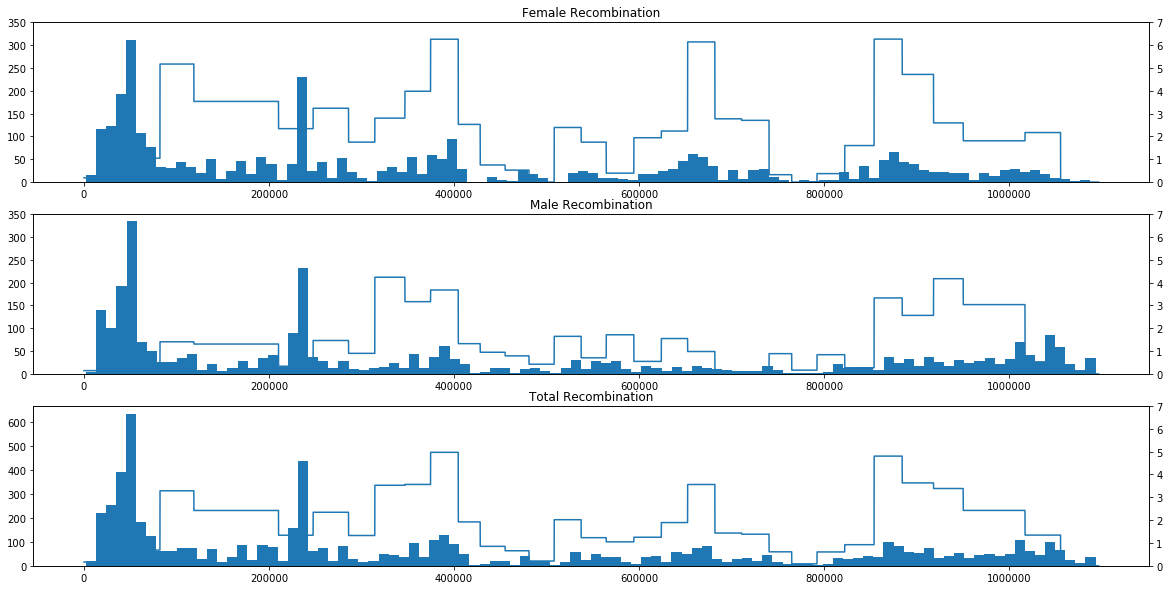

In [75]:
plt.figure(figsize=(20,10))
ax1 = plt.subplot(3, 1, 1)
ax1.hist(maternal_recombinations, bins=100)
ax1.set_ylim([0, 350])
ax2 = ax1.twinx()
ax2.plot(rec_female, label='Female Recomb')
ax2.set_ylim([0, 7])
plt.title('Female Recombination')

ax1 = plt.subplot(3, 1, 2)
ax1.hist(paternal_recombinations, bins=100)
ax1.set_ylim([0, 350])
ax2 = ax1.twinx()
ax2.plot(rec_male, label='Male Recomb')
ax2.set_ylim([0, 7])
plt.title('Male Recombination')

both_recombinations = maternal_recombinations + paternal_recombinations
both_recombinations.sort()
ax1 = plt.subplot(3, 1, 3)
ax1.hist(both_recombinations, bins=100)
#ax1.set_ylim([0, 350])
ax2 = ax1.twinx()
ax2.plot(rec, label='Male Recomb')
ax2.set_ylim([0, 7])
plt.title('Total Recombination')

plt.show()